<img src='https://micro.ce.sharif.edu/lib/tpl/writr/images/logo.svg' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Generative Models <br>
<font color=2565AE size=5>
Mathematics & Computer Science department - Fall 2024  <br>
<font color=3C99D size=5>
          Homework 5: Practical - Diffusion models <br>
<font color=696880 size=4>
AmirHossein Haji Mohammad Rezaei, Nasrin Amjadi
    
    
____

**Name :** Ali Ghasemzadeh

**Student ID :** 401106339

# Problem
This assignment uses PyTorch to build and implement a Denoising Diffusion Probabilistic model (DDPM) to learn the distribution of sprites images and evaluate its generated images by using FID score.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
from typing import Dict, Tuple
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

from tqdm import tqdm
import torch.nn.functional as F

## hyperparameters


In [2]:
# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '//kaggle/working/'

# training hyperparameters
batch_size = 100
n_epoch = 40
lrate=1e-3

## Sprites Dataset

In [3]:
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy'
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprite_labels_nc_1788_16x16.npy'

--2025-01-07 13:36:53--  https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.4, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/df/b9/dfb98dd9f5f7c221e653770544f82ac8de0044d1f52ab71a1e42ed1a332ae365/61cf3b7e3184f57f2bc2bf5e75fbcf08ba379241f58966c62a9716ef581b2916?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sprites_1788_16x16.npy%3B+filename%3D%22sprites_1788_16x16.npy%22%3B&Expires=1736516213&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNjUxNjIxM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2RmL2I5L2RmYjk4ZGQ5ZjVmN2MyMjFlNjUzNzcwNTQ0ZjgyYWM4ZGUwMDQ0ZDFmNTJhYjcxYTFlNDJlZDFhMzMyYWUzNjUvNjFjZjNiN2UzMTg0ZjU3ZjJiYz

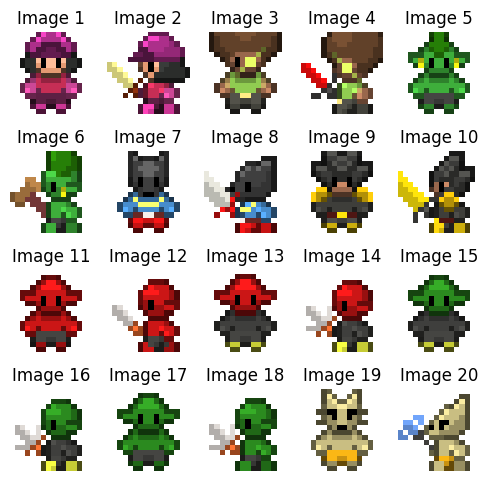

In [4]:
sprites_samples = np.load(save_dir + "sprites_1788_16x16.npy")[:20]
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()

# Loop through each image and plot it
for i in range(20):
    image = sprites_samples[i]

    # Plot the image in the appropriate subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f'Image {i + 1}')  # Set title

# Hide any unused subplots
for j in range(20, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [5]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, _sprites, _slabels, transform, null_context=False):
        self.transform = transform
        self.null_context = null_context
        self.sprites = _sprites
        self.slabels = _slabels
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

In [6]:
sprites = np.load(save_dir + "sprites_1788_16x16.npy")
slabels = np.load(save_dir + "sprite_labels_nc_1788_16x16.npy")

print(f"sprite shape: {sprites.shape}")
print(f"labels shape: {slabels.shape}")


train_sprites = sprites[:60000]
train_slabels = slabels[:60000]
val_sprites = sprites[60000:]
val_slabels = slabels[60000:]

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [7]:
# load dataset
trian_dataset = CustomDataset(train_sprites, train_slabels, transform, null_context=False)
train_dataloader = DataLoader(trian_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# load dataset
val_dataset = CustomDataset(val_sprites, val_slabels, transform, null_context=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

## UNet

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

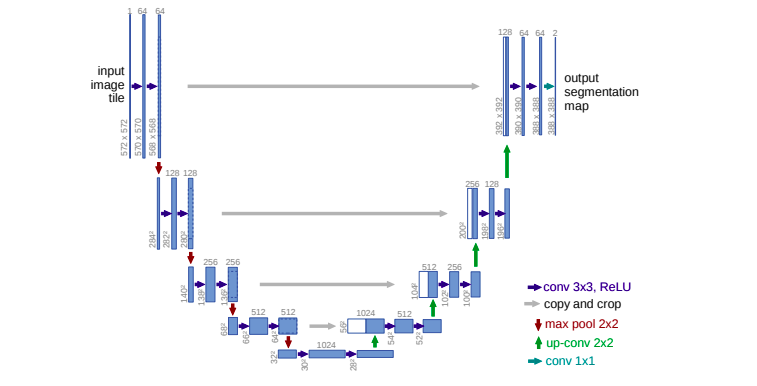

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization , segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [8]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [9]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(Unet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Training

In [10]:
# construct model
# TODO
nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
# nn_model.eval()

In [11]:
#construct optimizer
# TODO
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

We want to set up a "**variance schedule**" β, where $\beta_t$ specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. \\
At each time step t, the variance of the noise added to the previous step is predetermined by the variance schedule, and it's marked as $\beta_t$, where 0 < $\beta_1$ < $\beta_t$ < $\beta_2$ < 1.

In [12]:
# TODO: complete the code here
# Create Linear Scheduler - beta1 and beta2 are given in the hypermarapeters block
betas = torch.linspace(beta1, beta2, timesteps, dtype=torch.float32).to(device)
alphas = 1.0 - betas
alpha_prod = torch.cumprod(alphas, dim=0)
alpha_prod_prev = torch.cat([torch.tensor([1.0], device=device), alpha_prod[:-1]])

sqrt_alpha_prod = torch.sqrt(alpha_prod)
sqrt_one_minus_alpha_prod = torch.sqrt(1 - alpha_prod)
posterior_variance = betas * (1 - alpha_prod_prev) / (1 - alpha_prod)

print(f"betas: {betas.shape}, alphas: {alphas.shape}")
print(f"alpha_prod: {alpha_prod.shape}, sqrt_alpha_prod: {sqrt_alpha_prod.shape}")
print(f"posterior_variance: {posterior_variance.shape}")

betas: torch.Size([1000]), alphas: torch.Size([1000])
alpha_prod: torch.Size([1000]), sqrt_alpha_prod: torch.Size([1000])
posterior_variance: torch.Size([1000])


### Forward

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


In [13]:
# helper function: perturbs an image to a specified noise level
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)


# TODO: complete the code here
def perturb_input(x0, t):
    """
    Perturbs an image to a specified noise level.

    Parameters:
        x0: Tensor - Original image tensor.
        t: Tensor or int - Timestep indicating noise level.

    Returns:
        Tensor: Perturbed image.
    """
    if isinstance(t, int):
        t = torch.tensor([t], device=x0.device)

    alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)
    noise = torch.randn_like(x0).to(x0.device)
    noised_images = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

    return noised_images, noise

### Train Diffsion

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

In [14]:
def train_diffusion_model(model, optimizer, train_dataloader, val_dataloader, n_epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        model.train()
        with tqdm(train_dataloader, desc=f"Epoch {epoch}/{n_epochs} - Training", unit="batch") as pbar:
            i = 0
            for x0, _ in pbar:
                x0 = x0.to(device)
                t = torch.randint(0, len(alpha_bar), (x0.size(0),), device=device)
                xt, noise = perturb_input(x0, t)
                noise_pred = model(xt, t.float().unsqueeze(1))
                loss = F.mse_loss(noise_pred, noise)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                pbar.set_postfix({"Train Loss": loss.item()})
                # for debugging : 
                # i+=1
                # if i == 50:
                #   break

        # Validation loop
        model.eval()
        with torch.no_grad():
            with tqdm(val_dataloader, desc=f"Epoch {epoch}/{n_epochs} - Validation", unit="batch") as pbar:
                i = 0
                for x0, _ in pbar:
                    x0 = x0.to(device)
                    t = torch.randint(0, len(alpha_bar), (x0.size(0),), device=device)
                    xt, noise = perturb_input(x0, t)
                    noise_pred = model(xt, t.float().unsqueeze(1))
                    loss = F.mse_loss(noise_pred, noise)
                    val_loss += loss.item()
                    pbar.set_postfix({"Val Loss": loss.item()})
                    
                    # for debugging : 
                    # i+=1
                    # if i == 10:
                    #   break

        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    return train_losses, val_losses


In [15]:
# TODO
# implement the training loop for diffusion model
train_losses, val_losses = train_diffusion_model(
    model=nn_model,
    optimizer=optim,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    n_epochs=n_epoch,
    device=device
)

Epoch 1/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 59.10batch/s, Val Loss=0.257]


Epoch 1: Train Loss = 0.3041, Val Loss = 0.2424


Epoch 2/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 59.61batch/s, Val Loss=0.174]


Epoch 2: Train Loss = 0.2104, Val Loss = 0.1963


Epoch 3/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 59.23batch/s, Val Loss=0.189]


Epoch 3: Train Loss = 0.1836, Val Loss = 0.1853


Epoch 4/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 62.20batch/s, Val Loss=0.155]


Epoch 4: Train Loss = 0.1670, Val Loss = 0.1650


Epoch 5/40 - Validation: 100%|██████████| 294/294 [00:05<00:00, 57.91batch/s, Val Loss=0.205]


Epoch 5: Train Loss = 0.1553, Val Loss = 0.1535


Epoch 6/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 59.39batch/s, Val Loss=0.157]


Epoch 6: Train Loss = 0.1473, Val Loss = 0.1456


Epoch 7/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 62.35batch/s, Val Loss=0.15]


Epoch 7: Train Loss = 0.1400, Val Loss = 0.1389


Epoch 8/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 60.47batch/s, Val Loss=0.139]


Epoch 8: Train Loss = 0.1343, Val Loss = 0.1355


Epoch 9/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 58.91batch/s, Val Loss=0.155]


Epoch 9: Train Loss = 0.1288, Val Loss = 0.1294


Epoch 10/40 - Validation: 100%|██████████| 294/294 [00:05<00:00, 58.05batch/s, Val Loss=0.141]


Epoch 10: Train Loss = 0.1238, Val Loss = 0.1251


Epoch 11/40 - Validation: 100%|██████████| 294/294 [00:05<00:00, 57.71batch/s, Val Loss=0.103]


Epoch 11: Train Loss = 0.1208, Val Loss = 0.1220


Epoch 12/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 61.08batch/s, Val Loss=0.136]


Epoch 12: Train Loss = 0.1165, Val Loss = 0.1161


Epoch 13/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 61.10batch/s, Val Loss=0.123]


Epoch 13: Train Loss = 0.1140, Val Loss = 0.1134


Epoch 14/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 58.87batch/s, Val Loss=0.133]


Epoch 14: Train Loss = 0.1118, Val Loss = 0.1119


Epoch 15/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 61.08batch/s, Val Loss=0.101]


Epoch 15: Train Loss = 0.1086, Val Loss = 0.1113


Epoch 16/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 61.12batch/s, Val Loss=0.109]


Epoch 16: Train Loss = 0.1057, Val Loss = 0.1057


Epoch 17/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 60.06batch/s, Val Loss=0.104]


Epoch 17: Train Loss = 0.1043, Val Loss = 0.1082


Epoch 18/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 62.91batch/s, Val Loss=0.0798]


Epoch 18: Train Loss = 0.1022, Val Loss = 0.1028


Epoch 19/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 62.05batch/s, Val Loss=0.0899]


Epoch 19: Train Loss = 0.0999, Val Loss = 0.0991


Epoch 20/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 60.08batch/s, Val Loss=0.0996]


Epoch 20: Train Loss = 0.0991, Val Loss = 0.1005


Epoch 21/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 60.45batch/s, Val Loss=0.1]


Epoch 21: Train Loss = 0.0963, Val Loss = 0.0973


Epoch 22/40 - Validation: 100%|██████████| 294/294 [00:05<00:00, 58.50batch/s, Val Loss=0.0952]


Epoch 22: Train Loss = 0.0960, Val Loss = 0.0959


Epoch 23/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 61.04batch/s, Val Loss=0.0832]


Epoch 23: Train Loss = 0.0939, Val Loss = 0.0948


Epoch 24/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 61.28batch/s, Val Loss=0.107]


Epoch 24: Train Loss = 0.0920, Val Loss = 0.0897


Epoch 25/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 62.41batch/s, Val Loss=0.118]


Epoch 25: Train Loss = 0.0899, Val Loss = 0.0931


Epoch 26/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 65.11batch/s, Val Loss=0.0847]


Epoch 26: Train Loss = 0.0893, Val Loss = 0.0881


Epoch 27/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 60.86batch/s, Val Loss=0.0797]


Epoch 27: Train Loss = 0.0873, Val Loss = 0.0871


Epoch 28/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 61.60batch/s, Val Loss=0.106]


Epoch 28: Train Loss = 0.0866, Val Loss = 0.0902


Epoch 29/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 60.07batch/s, Val Loss=0.0939]


Epoch 29: Train Loss = 0.0850, Val Loss = 0.0833


Epoch 30/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 60.67batch/s, Val Loss=0.0854]


Epoch 30: Train Loss = 0.0839, Val Loss = 0.0825


Epoch 31/40 - Validation: 100%|██████████| 294/294 [00:05<00:00, 54.92batch/s, Val Loss=0.0886]


Epoch 31: Train Loss = 0.0829, Val Loss = 0.0824


Epoch 32/40 - Validation: 100%|██████████| 294/294 [00:05<00:00, 58.26batch/s, Val Loss=0.0875]


Epoch 32: Train Loss = 0.0812, Val Loss = 0.0812


Epoch 33/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 59.28batch/s, Val Loss=0.0721]


Epoch 33: Train Loss = 0.0809, Val Loss = 0.0788


Epoch 34/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 59.24batch/s, Val Loss=0.0736]


Epoch 34: Train Loss = 0.0791, Val Loss = 0.0784


Epoch 35/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 60.20batch/s, Val Loss=0.082]


Epoch 35: Train Loss = 0.0785, Val Loss = 0.0787


Epoch 36/40 - Validation: 100%|██████████| 294/294 [00:05<00:00, 56.99batch/s, Val Loss=0.102]


Epoch 36: Train Loss = 0.0774, Val Loss = 0.0763


Epoch 37/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 59.42batch/s, Val Loss=0.0752]


Epoch 37: Train Loss = 0.0762, Val Loss = 0.0740


Epoch 38/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 61.55batch/s, Val Loss=0.062]


Epoch 38: Train Loss = 0.0756, Val Loss = 0.0754


Epoch 39/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 61.36batch/s, Val Loss=0.052]


Epoch 39: Train Loss = 0.0750, Val Loss = 0.0730


Epoch 40/40 - Validation: 100%|██████████| 294/294 [00:04<00:00, 59.09batch/s, Val Loss=0.0823]

Epoch 40: Train Loss = 0.0747, Val Loss = 0.0719


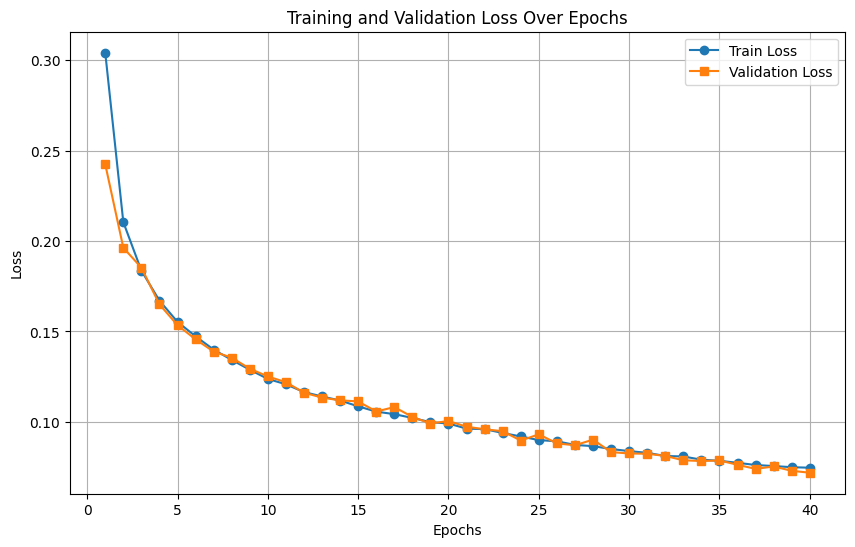

In [16]:
epochs = list(range(1, len(val_losses) + 1))

# TODO
# plot loss value for each epoch for train dataset and validation dataset
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## Reverse process: DDPM Sampling

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that looks like a real image. \\
Below image show the sampling algorithm

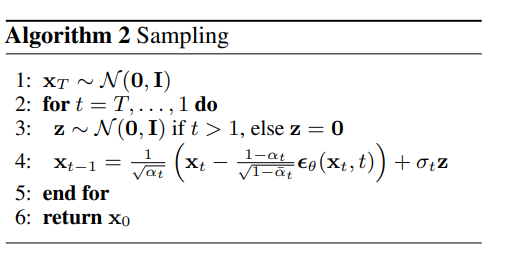

In [17]:
def p_xt_ddpm(current_noise_image, predicted_noise, time_step):
    # TODO
    # implement the denoising step for generating x_(t-1) from x_t in this function
    beta_t = beta[time_step]
    alpha_t = alpha[time_step]
    alpha_bar_t = alpha_bar[time_step]

    mean = (1 / torch.sqrt(alpha_t)) * (
        current_noise_image - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
    )

    if time_step > 0:
        noise = torch.randn_like(current_noise_image).to(current_noise_image.device)
        variance = torch.sqrt(beta_t)
        mean += variance * noise

    return mean

In [18]:
# TODO
# implement the generation function and plot the samples of reverse process for different time steps
def generate_samples_and_plot(model, n_steps, image_size, device, n_samples=1):
    x_t = torch.randn(n_samples, *image_size).to(device)
    images_progression = [x_t.clone()]

    for t in reversed(range(n_steps)):
        t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)
        predicted_noise = model(x_t, t_tensor.float().unsqueeze(1))
        x_t = p_xt_ddpm(x_t, predicted_noise, t)
        images_progression.append(x_t.clone())  # Save intermediate step

    plot_progression(images_progression)

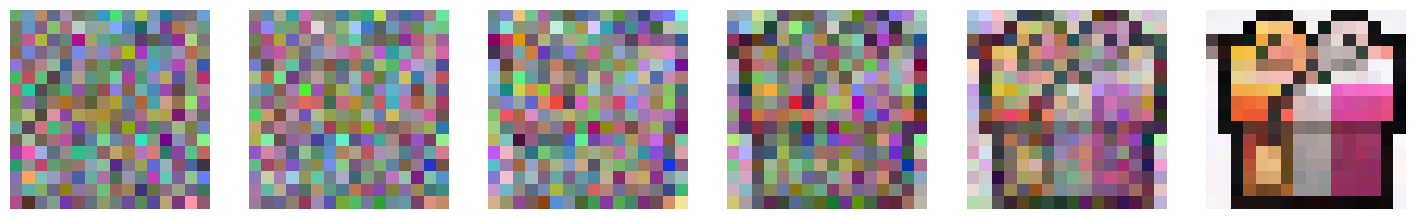

In [19]:
def plot_progression(images_progression):
    n_steps = len(images_progression) - 1
    indices = [0, n_steps // 5, 2 * n_steps // 5, 3 * n_steps // 5, 4 * n_steps // 5, n_steps]
    sampled_images = [images_progression[idx] for idx in indices]

    images = [img[0].detach().cpu().numpy() for img in sampled_images]  # Assume batch size = 1
    channels = images[0].shape[0]

    images = [
        img.transpose(1, 2, 0) if channels == 3 else img[0]
        for img in images
    ]

    images = [
        (img - img.min()) / (img.max() - img.min())
        for img in images
    ]

    fig, ax = plt.subplots(1, len(images), figsize=(len(images) * 3, 3))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap="gray" if channels == 1 else None)
        ax[i].axis("off")
    plt.show()



n_samples = 1
image_size = (3, height, height)
generate_samples_and_plot(nn_model, n_steps=n_steps, image_size=image_size, device=device, n_samples=n_samples)

## Reverse process: DDIM Sampling

Study the DDIM sampling method for reverse process and like the previous part, Implement this process regarding the DDIM method.

In [20]:
def p_xt_ddim(current_noise_image, predicted_noise, time_step, eta=0.0):
    # TODO
    # Implement the denoising step for generating x_(t-1) from x_t in this function
    alpha_bar_t = alpha_bar[time_step]
    alpha_bar_t_prev = alpha_bar[max(0, time_step - 1)]

    # Predicted image x0 based on the noise prediction
    x0_pred = (current_noise_image - torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_bar_t)

    # Compute x_(t-1)
    x_t_minus_1 = torch.sqrt(alpha_bar_t_prev) * x0_pred + torch.sqrt(1 - alpha_bar_t_prev - eta**2 * beta[time_step]) * (
        torch.randn_like(current_noise_image) if eta > 0 else 0
    )

    return x_t_minus_1
# TODO
# Implement the generation function and plot the samples of reverse process for different time steps

In [21]:
def generate_samples_ddim(model, n_steps, image_size, device, n_samples=1, eta=0.0):
    x_t = torch.randn(n_samples, *image_size).to(device)
    images_progression = [x_t.clone()]  # Store intermediate steps

    # Reverse process
    for t in reversed(range(n_steps)):
        t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)
        predicted_noise = model(x_t, t_tensor.float().unsqueeze(1))
        x_t = p_xt_ddim(x_t, predicted_noise, t, eta=eta)
        images_progression.append(x_t.clone())  # Save intermediate step

    return images_progression

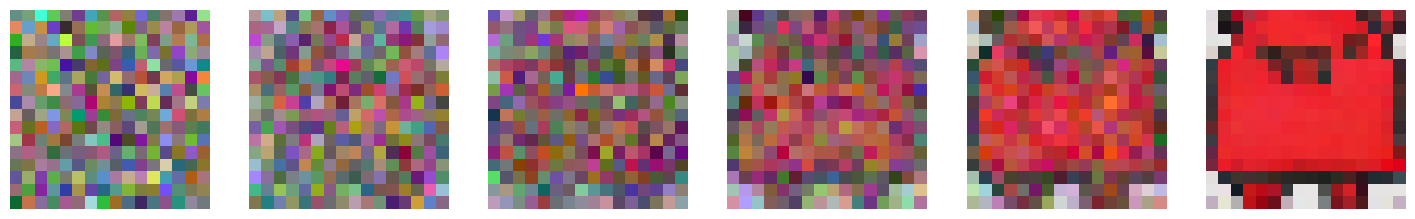

In [22]:
images_progression_ddim = generate_samples_ddim(
    model=nn_model,
    n_steps=n_steps,
    image_size=(3, height, height),
    device=device,
    n_samples=1,
    eta=0.01
)
plot_progression(images_progression_ddim)

## Results

Plot 20 generated images by each of generation processes implemented in the previous part

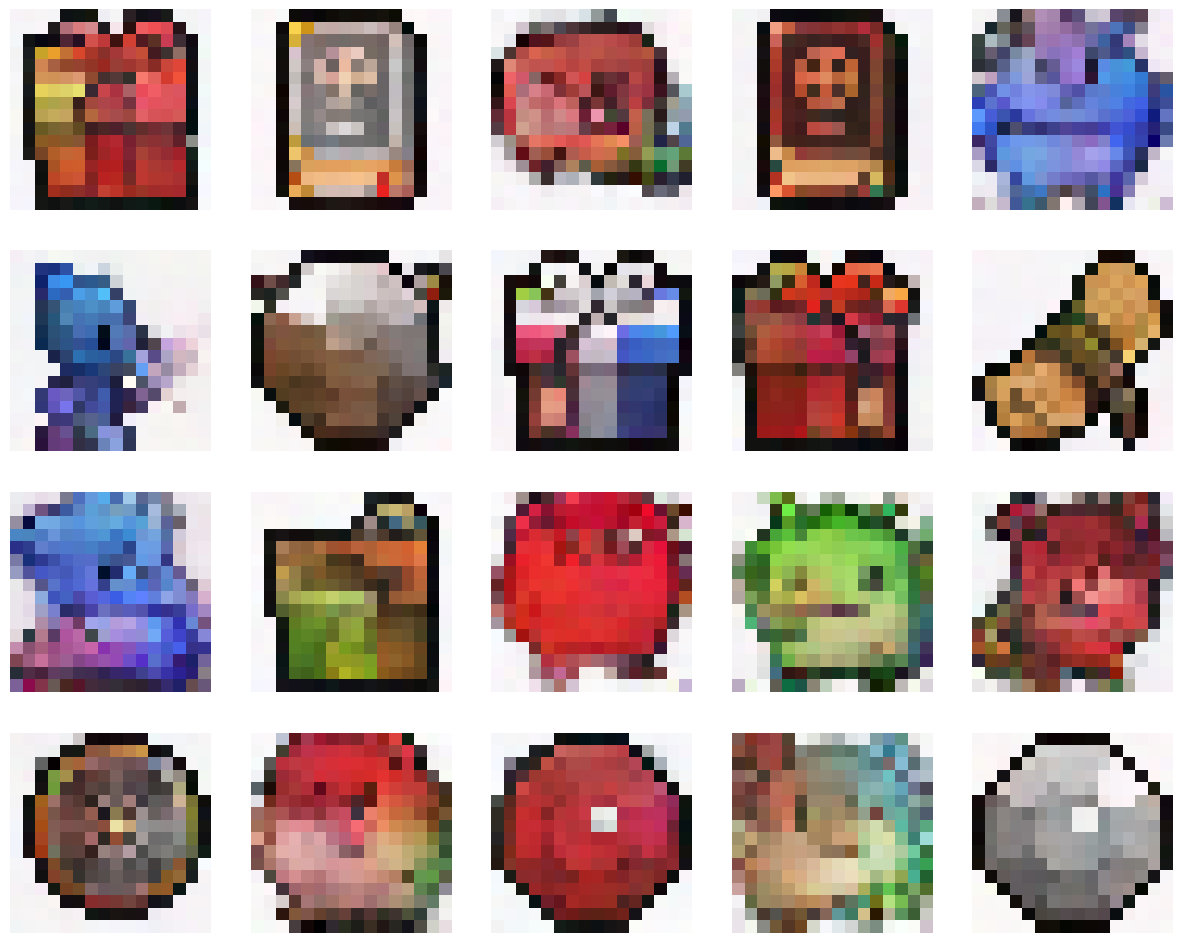

In [23]:
# TODO
# implement 20 images generated by DDPM sampling method
def generate_and_plot_ddpm(model, n_steps, image_size, device, n_samples=20):
    """
    Generates and plots 20 images using the DDPM sampling method.

    Parameters:
        model: nn.Module - The trained diffusion model (e.g., U-Net).
        n_steps: int - Total number of time steps (T).
        image_size: tuple - Size of the generated images (channels, height, width).
        device: torch.device - The device to run the process on.
        n_samples: int - Number of images to generate.
    """
    # Generate samples
    generated_images = []
    for _ in range(n_samples):
        x_t = torch.randn(1, *image_size).to(device)  # Start with pure noise
        for t in reversed(range(n_steps)):
            t_tensor = torch.full((1,), t, device=device, dtype=torch.long)
            predicted_noise = model(x_t, t_tensor.float().unsqueeze(1))
            x_t = p_xt_ddpm(x_t, predicted_noise, t)
        generated_images.append(x_t[0].detach().cpu().numpy())

    # Plot all images
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    for i, ax in enumerate(axes.flatten()):
        img = generated_images[i]
        channels = img.shape[0]
        if channels == 3:
            img = img.transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C) for RGB
        else:
            img = img[0]  # Grayscale
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        ax.imshow(img, cmap="gray" if channels == 1 else None)
        ax.axis("off")
    plt.show()

generate_and_plot_ddpm(
    model=nn_model,
    n_steps=n_steps,
    image_size=(3, height, height),  # Adjust based on your dataset
    device=device,
    n_samples=20
)

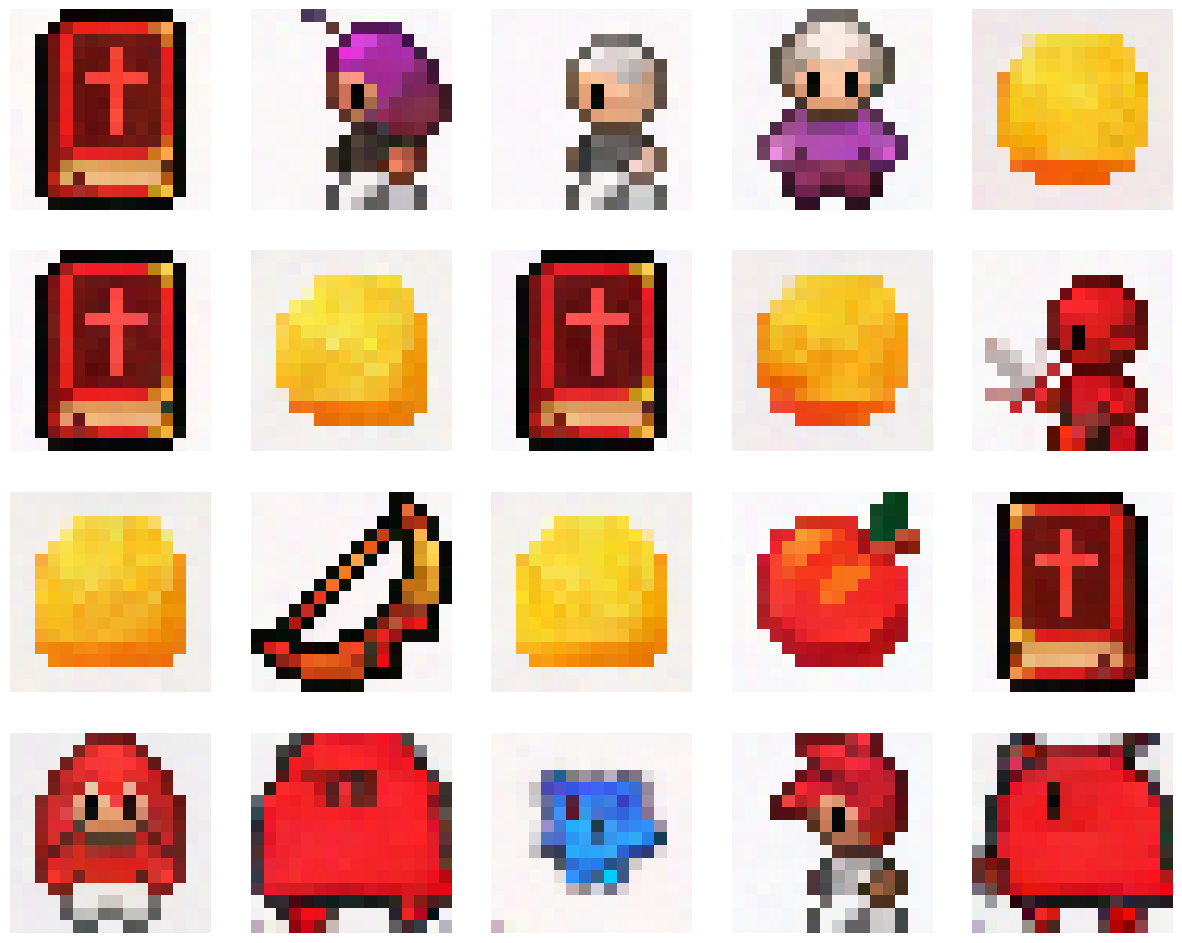

In [24]:
# TODO
# implement 20 images generated by DDIM sampling method
def generate_and_plot_ddim(model, n_steps, image_size, device, n_samples=20, eta=0.0):
    generated_images = []
    for _ in range(n_samples):
        x_t = torch.randn(1, *image_size).to(device)
        for t in reversed(range(n_steps)):
            t_tensor = torch.full((1,), t, device=device, dtype=torch.long)
            predicted_noise = model(x_t, t_tensor.float().unsqueeze(1))
            x_t = p_xt_ddim(x_t, predicted_noise, t, eta=eta)
        generated_images.append(x_t[0].detach().cpu().numpy())

    # Plot all images
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    for i, ax in enumerate(axes.flatten()):
        img = generated_images[i]
        channels = img.shape[0]
        if channels == 3:
            img = img.transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C) for RGB
        else:
            img = img[0]
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        ax.imshow(img, cmap="gray" if channels == 1 else None)
        ax.axis("off")
    plt.show()

generate_and_plot_ddim(
    model=nn_model,
    n_steps=n_steps,
    image_size=(3, height, height),
    device=device,
    n_samples=20,
    eta=0.01
)

# Evaluating the Generated Samples:

Now we want to evaluate our model. For this, we use the FID score.

First, read [this link](https://github.com/mseitzer/pytorch-fid) to become familiar with this metric and its usage in your code.

Installation

In [25]:
!pip install -qq pytorch-fid

Generate 3000 images by your model (by using either of generation processes) and save them in a directory. Also, save 3000 images from the sprites dataset and save them in another directory.

In [26]:
num_samples = 3000

In [27]:
# TODO
# save generated images and real images
real_images_dir = "real_images"
generated_images_dir = "generated_images"
os.makedirs(real_images_dir, exist_ok=True)
os.makedirs(generated_images_dir, exist_ok=True)

def save_real_images(dataset, save_dir, num_images=3000):
    for i in range(num_images):
        image, _ = dataset[i]
        save_path = os.path.join(save_dir, f"real_image_{i + 1}.png")
        save_image(image, save_path)

save_real_images(trian_dataset, real_images_dir, num_images=num_samples)

In [28]:
def save_generated_images(model, save_dir, num_images=3000, n_steps=100, image_size=(3, 16, 16), device=device):
    for i in range(num_images):
        x_t = torch.randn(1, *image_size).to(device)
        for t in reversed(range(n_steps)):
            t_tensor = torch.full((1,), t, device=device, dtype=torch.long)
            predicted_noise = model(x_t, t_tensor.float().unsqueeze(1))
            x_t = p_xt_ddpm(x_t, predicted_noise, t)

        save_path = os.path.join(save_dir, f"generated_image_{i + 1}.png")
        save_image(x_t[0], save_path)

save_generated_images(nn_model, generated_images_dir, num_images=num_samples, n_steps=n_steps, image_size=(3, height, height), device=device)

In [29]:
# TODO: compute the FID score using pytorch-fid package.
# You should have two image directories to compute the score:
# 1- Directory of the original images.
# 2- Directory of the generated images (the directory that you created in the last code cell)
def compute_fid_score(real_images_dir, generated_images_dir):
    from pytorch_fid import fid_score

    fid_value = fid_score.calculate_fid_given_paths([real_images_dir, generated_images_dir],
                                                    batch_size=150,
                                                    device=str(device),
                                                    dims=2048)

    print(f"FID Score: {fid_value}")
    return fid_value
    
fid_score_value = compute_fid_score(real_images_dir, generated_images_dir)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 246MB/s]
100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


FID Score: 62.3909029189295
